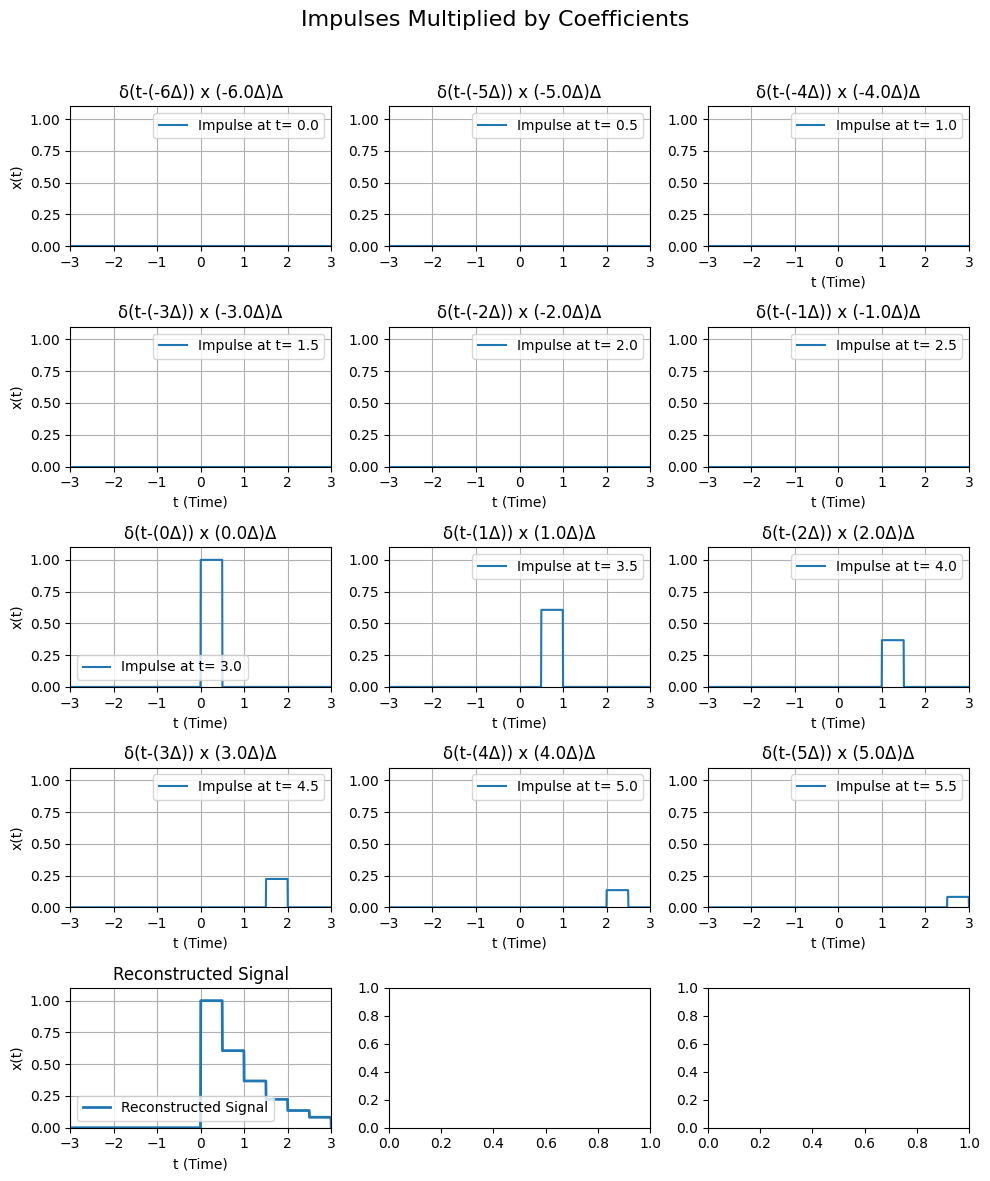

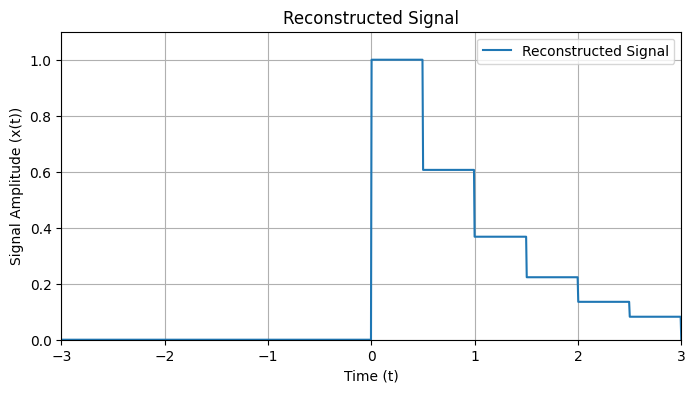

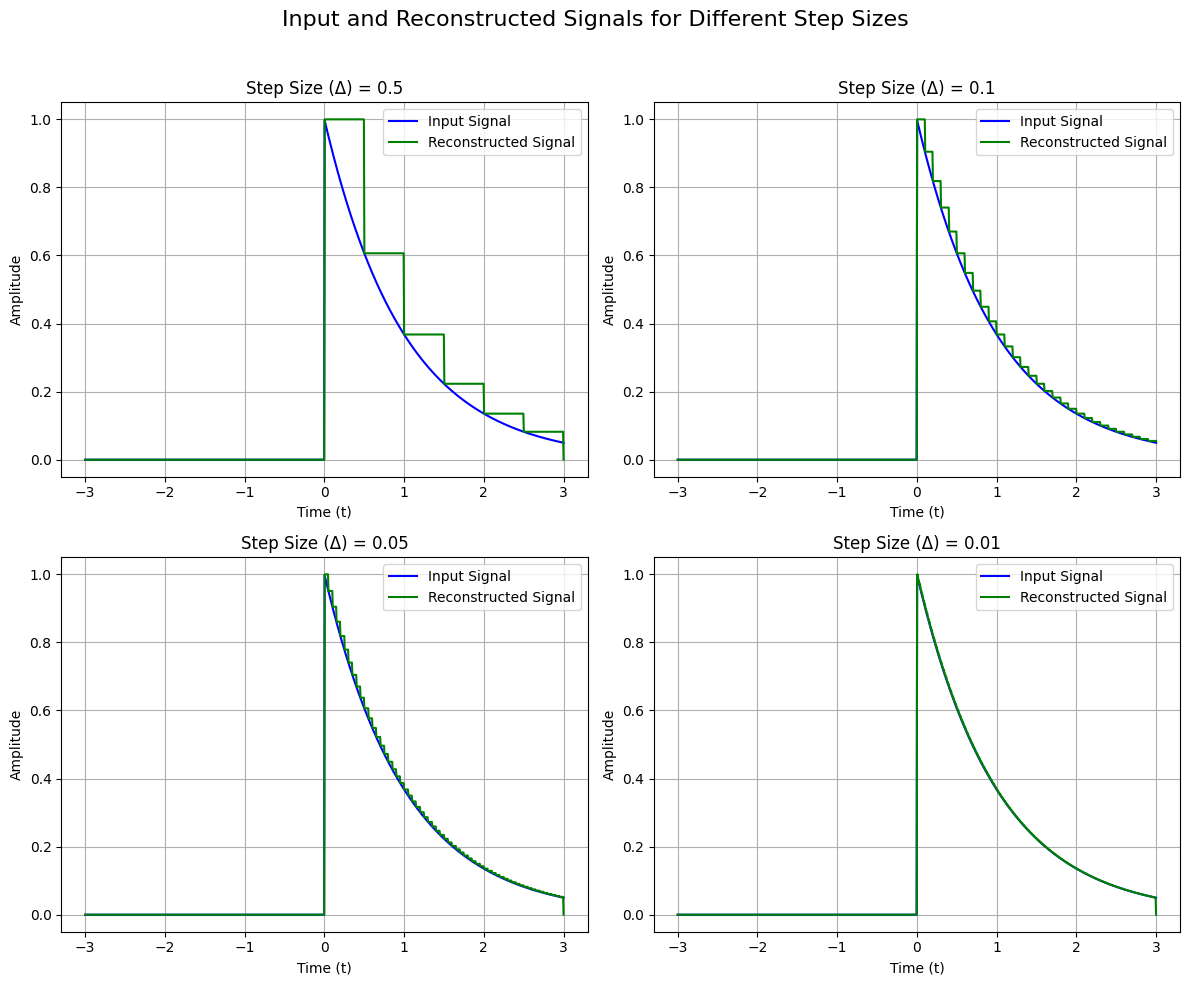

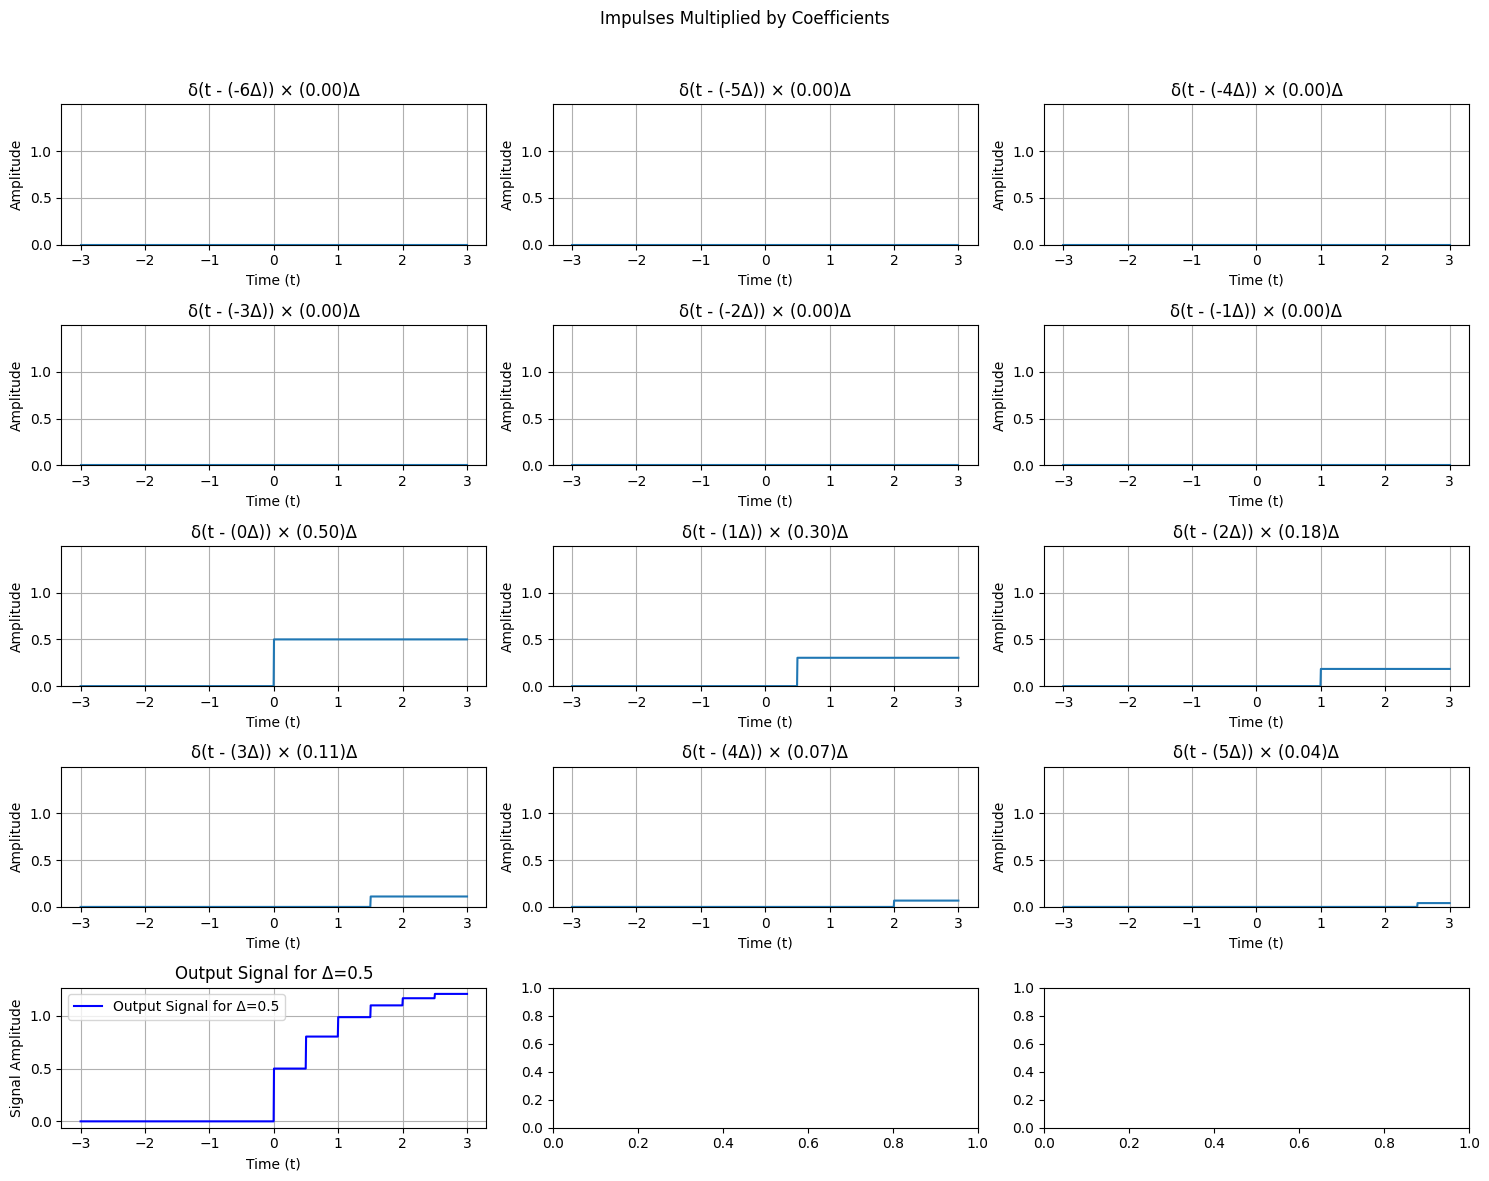

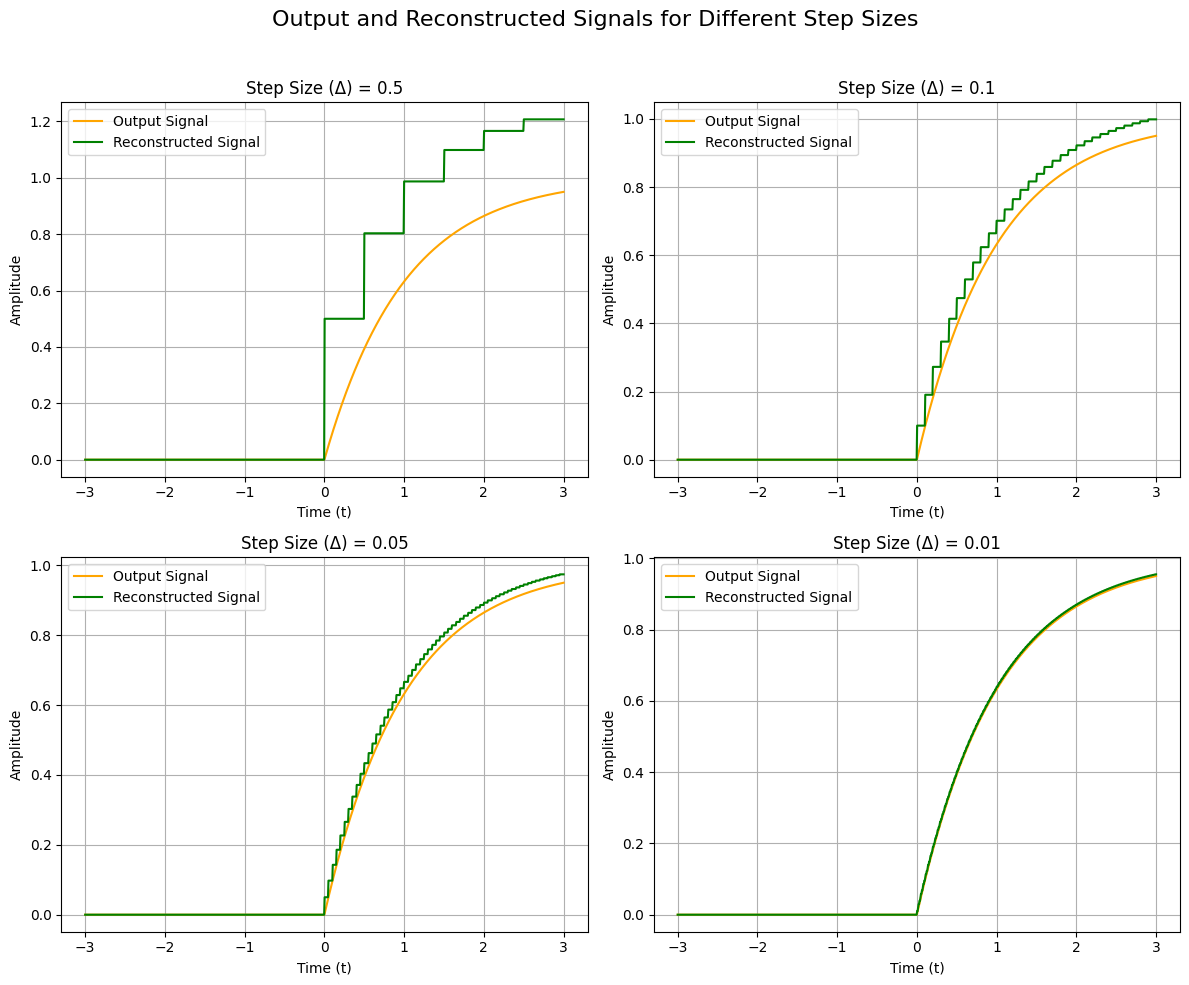

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os


img_root_path = 'continuousSignal'
os.makedirs(img_root_path, exist_ok=True)



class ContinuousSignal:
    def __init__(self,func) :
      self.func=func

    def shift(self,shift):
       return ContinuousSignal(lambda t: self.func(t - shift))
    
    def add(self,other):
       return ContinuousSignal(lambda t: self.func(t) + other.func(t))
    
    def multiply(self, other):
       return ContinuousSignal(lambda t: self.func(t) * other.func(t))
    
    def multiply_const_factor(self,factor):
       return ContinuousSignal(lambda t: factor * self.func(t))
    
    def plot(self, t_range=(-3, 3), num_points=1000, title=None, x_label='t (Time)', y_label='x(t)', saveTo=None, color='blue'):
        t = np.linspace(t_range[0], t_range[1], num_points)
        y = self.func(t)

        plt.figure(figsize=(8, 4))
        plt.plot(t, y, color=color)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.grid(True)

        if saveTo:
            plt.savefig(saveTo)

        plt.show()

    


class LTIContinuous:
   def __init__(self,impulse_response):
      self.impulse_response = impulse_response

   def linear_combination_of_impulse(self, signal_input, delta, num_points):
    if delta <= 0:
        raise ValueError("Step size must be a positive value.")

    n_vals = np.arange(-3/delta, 3/delta, 1)
    time_values = np.linspace(-3, 3, num_points)
    impulse_list = []
    coeff_list = []
    for n in n_vals:
        impulse_signal = np.where((time_values >= n * delta) & (time_values < n * delta + delta), 1, 0)
        impulse_list.append(impulse_signal)
        coeff_list.append(signal_input.func(n * delta))
        
    return np.array(impulse_list), np.array(coeff_list), time_values


   def output_approx(self, signal_input, delta, num_points):
    impulse_signals, coeff_values, time_vals = self.linear_combination_of_impulse(signal_input, delta, num_points)
    output_signal = np.zeros_like(time_vals, dtype=float)
    
    for index, (impulse_signal, coeff) in enumerate(zip(impulse_signals, coeff_values)):
        shifted_impulse = self.impulse_response.shift(index * delta - 3)
        shifted_response = shifted_impulse.func(time_vals) * delta
        output_signal += coeff * shifted_response
        
    return output_signal, impulse_signals, coeff_values, time_vals


   def decompose_into_impulses(self, signal_input, delta):
    n_indices = np.arange(-6, 6, 1)
    time_samples = n_indices * delta
    input_values = signal_input.func(time_samples)
    impulse_list = []
    coeff_list = []
    for index, time in enumerate(time_samples):
        shifted_impulse_signal = self.impulse_response.shift(time)
        coeff = input_values[index] * delta
        impulse_list.append(shifted_impulse_signal.multiply_const_factor(coeff))
        coeff_list.append(coeff)
    return impulse_list, coeff_list, time_samples, n_indices





   def approximate_output_signal(self, signal_input, delta):
    impulse_list, coeff_list, time_samples, n_indices = self.decompose_into_impulses(signal_input, delta)
    
    def compute_output(t):
        output_signal = np.zeros_like(t)
        for idx, impulse in enumerate(impulse_list):
            output_signal += impulse.func(t)  
        return output_signal

    output_signal_instance = ContinuousSignal(compute_output)
    return output_signal_instance, impulse_list, coeff_list, time_samples, n_indices


def plot_output_signal(lti_system, signal_input, delta, num_points):
    output_signal, _, _, time_range = lti_system.output_approx(signal_input, delta, num_points)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_range, output_signal, label='Output Signal', color='blue')
    plt.title('Output Signal from LTI System')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.xlim(time_range[0], time_range[-1])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_impulse_coeff(lti_system, signal_input, delta, num_points, img_root_path):
    _, impulse_signals, coeff_values, time_range = lti_system.output_approx(signal_input, delta, num_points)
    
    fig, axs = plt.subplots(5, 3, figsize=(10, 12))
    fig.suptitle('Impulses Multiplied by Coefficients', fontsize=16)
    offset = -6
    
    for index, ax in enumerate(axs.flatten()):
        if index < len(coeff_values):
            ax.plot(time_range, coeff_values[index] * impulse_signals[index], 
                    label=f'Impulse at t={index * delta  : .1f}')
            ax.set_title(f'δ(t-({offset}Δ)) x ({offset}.0Δ)Δ')
            offset+=1
            ax.set_xlim([-3, 3])
            ax.set_ylim([0, 1.1])
            ax.grid(True)
            ax.legend()
            if index%3 == 0:
                ax.set_ylabel('x(t)')
            if index >=len(axs) - 3:
                ax.set_xlabel('t (Time)')
    ax = axs.flatten()[12]
    reconstructed_signal = np.sum([c * i for c, i in zip(coeff_values, impulse_signals)], axis=0)
    ax.plot(time_range, reconstructed_signal, label='Reconstructed Signal', linewidth=2)
    ax.set_title('Reconstructed Signal')
    ax.set_xlabel('t (Time)')
    ax.set_ylabel('x(t)')
    ax.set_xlim([-3, 3])
    ax.set_ylim([0, 1.1])
    ax.grid(True)
    ax.legend()            

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{img_root_path}/impulse_coefficients_plot.png', dpi=300)
    plt.show()


def plot_reconstructed_signal(lti_system, signal_input, delta, num_points, img_root_path):
    _, impulse_signals, coeff_values, time_range = lti_system.output_approx(signal_input, delta, num_points)
    
    plt.figure(figsize=(8, 4))
    plt.plot(time_range, np.sum([c * i for c, i in zip(coeff_values, impulse_signals)], axis=0), label="Reconstructed Signal")
    
    plt.title("Reconstructed Signal")
    plt.xlabel('Time (t)')
    plt.ylabel('Signal Amplitude (x(t))')
    plt.grid(True)
    plt.legend()
    plt.xlim([-3, 3])
    plt.ylim([0, 1.1])
    plt.savefig(f'{img_root_path}/reconstructed_signal.png', dpi=300)
    plt.show()


def plot_input_and_reconstructed_signals(lti_system, signal_input, step_values, num_points,img_root_path):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Input and Reconstructed Signals for Different Step Sizes', fontsize=16)
    for index, delta in enumerate(step_values):
        _, impulse_signals, coeff_values, time_range = lti_system.output_approx(signal_input, delta, num_points)
        reconstructed_signal = np.zeros_like(time_range, dtype=float)
        for i in range(len(coeff_values)):
            reconstructed_signal += coeff_values[i] * impulse_signals[i]
        ax = axs[index // 2, index % 2]
        ax.plot(time_range, signal_input.func(time_range), label='Input Signal', color='blue')
        ax.plot(time_range, reconstructed_signal, label='Reconstructed Signal', color='green')
        ax.set_title(f'Step Size (Δ) = {delta}')
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{img_root_path}/input_reconstructed_signals.png', dpi=300)
    plt.show()


def plot_output_and_reconstructed_signals(lti_system, signal_input, step_values, num_points, response_function,img_root_path):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Output and Reconstructed Signals for Different Step Sizes', fontsize=16)

    for index, delta in enumerate(step_values):
        output_signal, impulse_signals, coeff_values, time_range = lti_system.output_approx(signal_input, delta, num_points)
        
        reconstructed_signal = np.zeros_like(time_range, dtype=float)
        for i in range(len(coeff_values)):
            reconstructed_signal += coeff_values[i] * impulse_signals[i]
        
        ax = axs[index // 2, index % 2]
        ax.plot(time_range, response_function(time_range), label='Output Signal', color='orange')
        ax.plot(time_range, output_signal, label='Reconstructed Signal', color='green')
        ax.set_title(f'Step Size (Δ) = {delta}')
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{img_root_path}/output_reconstructed_signals.png', dpi=300)
    plt.show()

def generate_input_signal(t):
    return np.where(t < 0, 0, np.exp(-t))




def generate_impulse_response(t):
    return np.where(t >= 0, 1, 0)



def generate_response_signal(t):
    return np.where(t < 0, 0, 1 - np.exp(-t))



def main():
    input_signal_func_instance = ContinuousSignal(generate_input_signal)
    impulse_response_instance = ContinuousSignal(generate_impulse_response)
    lti_system_instance = LTIContinuous(impulse_response_instance)

    delta = 0.5
    num_points = 1000
    delta_values = [0.5, 0.1, 0.05, 0.01]

    
    plot_impulse_coeff(lti_system_instance, input_signal_func_instance, delta, num_points,img_root_path)
    plot_reconstructed_signal(lti_system_instance, input_signal_func_instance, delta, num_points,img_root_path)
    plot_input_and_reconstructed_signals(lti_system_instance, input_signal_func_instance, delta_values, num_points,img_root_path)
    #plot_output_and_reconstructed_signals(lti_system_instance, input_signal_func_instance, delta_values, num_points, img_root_path)

    
    output_signal_instance, impulse_signals, coeff_values, t_values, n_values = lti_system_instance.approximate_output_signal(input_signal_func_instance, delta=0.5)

    fig, axes = plt.subplots(5, 3, figsize=(15, 12))
    fig.suptitle('Impulses Multiplied by Coefficients')

    
    output_t_values = np.linspace(-3, 3, 1000)  
    output_signal_values = output_signal_instance.func(output_t_values)  
    if np.ndim(output_signal_values) == 0:  
        output_signal_values = np.full_like(output_t_values, output_signal_values)  

    
    if output_signal_values.shape != output_t_values.shape:
        print(f"Shape mismatch: output_signal_values: {output_signal_values.shape}, output_t_values: {output_t_values.shape}")
        return

    
    axes.flatten()[12].plot(output_t_values, output_signal_values, label='Output Signal for Δ=0.5', color='blue')
    axes.flatten()[12].set_title(f'Output Signal for Δ={delta}')
    axes.flatten()[12].set_xlabel('Time (t)')
    axes.flatten()[12].set_ylabel('Signal Amplitude')
    axes.flatten()[12].grid(True)
    axes.flatten()[12].legend()

    
    for i, ax in enumerate(axes.flatten()[:12]): 
        ax.plot(np.linspace(-3, 3, 1000), impulse_signals[i].func(np.linspace(-3, 3, 1000)))
        ax.set_ylim(0, 1.5) 
        ax.set_yticks(np.arange(0, 1.3, 0.5))  
        ax.set_title(f"δ(t - ({n_values[i]}Δ)) × ({coeff_values[i]:.2f})Δ")
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{img_root_path}/impulses_coefficients.png', dpi=300)
    plt.show()
    plot_output_and_reconstructed_signals(lti_system_instance, input_signal_func_instance, delta_values, num_points, generate_response_signal, img_root_path)
main()

